In [3]:
!pip install keras-tuner -q

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input



tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.1


In [6]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Dataset folders 
dataset_dir = '/notebooks/datasetBea'
training_dir = "/notebooks/datasetBea/train"
validation_dir = "/notebooks/datasetBea/val"

In [8]:
# All the categories to classify the dataset
labels = ['Species1',              # 0
          'Species2',          # 1
          "Species3",             # 2
          "Species4",          # 3
          "Species5",            # 4
          "Species6",             # 5
          "Species7",         # 6
          "Species8"]             # 7

In [9]:
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=15,
                                        width_shift_range=15,
                                        zoom_range=0.3,
                                        shear_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(120,120),
                                                       interpolation="bicubic",
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=128,
                                                       shuffle=True,
                                                       seed=seed)

valid_data_gen = ImageDataGenerator(rescale=1/255.)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(120,120),
                                               interpolation="bicubic",
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [12]:
def get_next_batch(generator):
  batch = next(generator)
    
  print("batch \n")
  #print(batch)

  image = batch[0]*255
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

batch 

(Input) image shape: (128, 120, 120, 3)
Target shape: (128, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


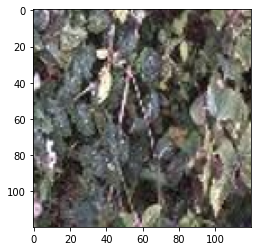

In [13]:
# Get a sample from dataset and show info
_ = get_next_batch(valid_gen)

In [14]:
epo = 120
init_lr = 1e-3
bs = 256
image_dims = (224, 224, 3)

In [15]:
class_weights = {0: 2.389358108108108, 
                 1: 0.8320588235294117, 
                 2: 0.8583131067961165, 
                 3: 0.8667279411764706, 
                 4: 0.8340212264150944, 
                 5: 1.9978813559322033, 
                 6: 0.8243006993006993, 
                 7: 0.8709975369458128}

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner


def build_model(hp):

    base_model1 = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

    for layer in base_model1.layers[:15]: 
        layer.trainable = False 

    for layer in base_model1.layers[15:]: 
        layer.trainable = True

    inputs=tfk.Input(shape=(120,120,3))
    #x = tfk.layers.Resizing(96,96,interpolation="bicubic")(inputs) 
    #x=base_model1(x)  
    x = base_model1(inputs)
    x = Flatten()(x)
    for i in range( hp.Int("num_layers",2,3)):
        x=Dropout(hp.Float(f"droput_rate_{i}",min_value=0.0,max_value = 0.8,step=0.2))(x)
        x = Dense(units = hp.Int("num_units",min_value=64,max_value=256,step=64),
                  activation= "relu")(x)
    outputs = Dense(8, activation='softmax')(x)

    model1 = Model(inputs=inputs, outputs=outputs)
    print (model1.summary())
    opt = Adam(learning_rate=hp.Float("lr",min_value=1e-4, max_value=1e-2 ))
    model1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model1
 

In [17]:



tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=44,
    executions_per_trial=1,
    overwrite=False,
    directory="tuning_folder",
    project_name="vgg19_BayesianOpt1",
)
tuner.search_space_summary()


INFO:tensorflow:Reloading Oracle from existing project tuning_folder/vgg19_BayesianOpt1/oracle.json
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 64)                294976    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                           

In [18]:
    
cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
               tf.keras.callbacks.ModelCheckpoint(filepath='/notebooks/model_checkpoints/bayesianOptVgg19.h5',verbose=1,monitor='val_accuracy', save_best_only=True, mode='max'),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
#load model
tuner.search(aug_train_gen,
                 epochs=epo,
                 validation_data=valid_gen,
                 class_weight= class_weights,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training



Search: Running Trial #44

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
0                 |0                 |droput_rate_0
128               |128               |num_units
0                 |0                 |droput_rate_1
0.0001            |0.0001            |lr
0.8               |0.8               |droput_rate_2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
               

KeyboardInterrupt: 

In [19]:
tuner.results_summary()

Results summary
Results in tuning_folder/vgg19_BayesianOpt1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.0
num_units: 128
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.8
Score: 0.8246844410896301
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.0
num_units: 192
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.8
Score: 0.8162692785263062
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.0
num_units: 64
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.4
Score: 0.8120617270469666
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.4
num_units: 192
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.0
Score: 0.8106591701507568
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.0
num_units: 64
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.0
Score: 0.8092566728591919
Trial summary
Hyperparameters:
num_layers: 2
droput_rate_0: 0.0
num_units: 256
droput_rate_1: 0.0
lr: 0.0001
droput_rate_2: 0.8
Score: 0.805049061775

In [20]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 96, 96))
best_model.summary()
best_model.save("BestModelVgg19BayesianOpt1")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512 

INFO:tensorflow:Assets written to: BestModelVgg19BayesianOpt1/assets


INFO:tensorflow:Assets written to: BestModelVgg19BayesianOpt1/assets


In [14]:
opt = Adam(learning_rate=init_lr)
model1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])    
cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
               tf.keras.callbacks.ModelCheckpoint(filepath='/notebooks/model_checkpoints/bea_base_vgg.h5',verbose=1,monitor='val_accuracy', save_best_only=True, mode='max'),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
#load model
#filepath="/content/drive/MyDrive/models/model3.18-0.11.h5"
#model1=load_model(filepath)

# Train the model with the new callback

hist1 = model1.fit(aug_train_gen,
                 epochs=epo,
                 validation_data=valid_gen,
                 class_weight= class_weights,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training


Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 2.1410 - accuracy: 0.1389
Epoch 1: val_accuracy improved from -inf to 0.15708, saving model to /notebooks/model_checkpoints/bea_base_vgg.h5
12/12 [==============================] - 9s 679ms/step - loss: 2.1410 - accuracy: 0.1389 - val_loss: 2.0446 - val_accuracy: 0.1571
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 2.0334 - accuracy: 0.1552
Epoch 2: val_accuracy improved from 0.15708 to 0.25806, saving model to /notebooks/model_checkpoints/bea_base_vgg.h5
12/12 [==============================] - 8s 642ms/step - loss: 2.0334 - accuracy: 0.1552 - val_loss: 1.8310 - val_accuracy: 0.2581
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.9164 - accuracy: 0.2142
Epoch 3: val_accuracy improved from 0.25806 to 0.29874, saving model to /notebooks/model_checkpoints/bea_base_vgg.h5
12/12 [==============================] - 8s 647ms/step - loss: 1.9164 - accuracy: 0.2142 - val_loss: 1.83

In [15]:
print (hist1)
import pickle
model1.save("model_bea_base_mauri_vggScolastico3")
with open('trainhist1', 'wb') as file_pi:
      pickle.dump(hist1, file_pi)

INFO:tensorflow:Assets written to: model_bea_base_mauri_vggScolastico3/assets


INFO:tensorflow:Assets written to: model_bea_base_mauri_vggScolastico3/assets


INFO:tensorflow:Assets written to: ram://63d369d8-b1c1-46d9-9372-4e084c363438/assets


INFO:tensorflow:Assets written to: ram://63d369d8-b1c1-46d9-9372-4e084c363438/assets


batch 

(Input) image shape: (256, 96, 96, 3)
Target shape: (256, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2
8/8 [==============================] - 1s 19ms/step


<AxesSubplot:>

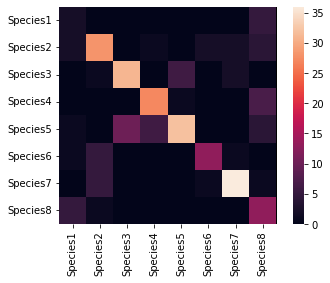

In [16]:
x,y=get_next_batch(valid_gen)
predictions=model1.predict(x)
predictions.shape
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm.T,xticklabels=list(labels), yticklabels=list(labels))


In [ ]:
hist1 = pickle.load(open('trainhist1', "rb"))
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist1.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['accuracy'], epoch_list, hist1.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist1.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['loss'], epoch_list, hist1.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()